<a href="https://colab.research.google.com/github/zekaouinoureddine/Advanced-transformer-based-models-on-opinion-mining/blob/master/notebooks/Movie_Reviews_BERT_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<h1 align="center"><strong>Movie Reviews BERT</strong></h1>

---

In [ ]:
!pip install transformers -q

     |████████████████████████████████| 4.0 MB 14.4 MB/s 
     |████████████████████████████████| 596 kB 91.9 MB/s 
     |████████████████████████████████| 77 kB 9.4 MB/s 
     |████████████████████████████████| 6.6 MB 85.2 MB/s 
     |████████████████████████████████| 895 kB 85.8 MB/s 


### Required Libraries

In [ ]:
import re
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn import metrics

from collections import defaultdict


import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

In [ ]:
!gdown --id 1xJYm-tNMllxx82_CQ1K1R5q0JW9KUV1j -q
!unzip IMDb.zip

### Utils

In [ ]:
def decontracted(x):
  x = str(x).lower()
  x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
  .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
  .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
  .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
  .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
  .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
  .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
  .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
  .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
  .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
  .replace("'cause'"," because")
    
  x = re.sub(r"([0-9]+)000000", r"\1m", x)
  x = re.sub(r"([0-9]+)000", r"\1k", x)
  return x

def remove_html(sentence): 
  pattern = re.compile('<.*?>')
  cleaned_sentence = re.sub(pattern,' ',sentence)
  return cleaned_sentence

def remove_url(sentence):
  text = re.sub(r"http\S+", " ", sentence)
  cleaned_sentence = re.sub(r"www.\S+", " ", text)
  return cleaned_sentence

def remove_punctuations(sentence):
  cleaned_sentence  = re.sub('[^a-zA-Z]',' ',sentence)
  return cleaned_sentence

def remove_patterns(sentence): 
  cleaned_sentence = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
  return cleaned_sentence

def remove_stopwords(sentence):
  default_stopwords = set(nltk.corpus.stopwords.words('english'))
  remove_not = set(['no', 'nor', 'not'])
  custom_stopwords = default_stopwords - remove_not
  review = [words.lower() for words in sentence.split() if words not in custom_stopwords]
  cleaned_sentence = " ".join(review)
  return cleaned_sentence

def stem_text(sentence):
  stemmer = PorterStemmer()
  stemmed_sentence = stemmer.stem(sentence)
  return stemmed_sentence

def lemmatize_text(sentence):
  lemmatizer = WordNetLemmatizer()
  lemmatized_sentence = lemmatizer.lemmatize(sentence)
  return lemmatized_sentence

def clean_data(sentence):
  cleaned_sentence = lemmatize_text(stem_text(remove_stopwords(remove_patterns(remove_punctuations(remove_url(remove_html(decontracted(sentence))))))))
  return cleaned_sentence

def preprocess_data(df, column_name:str):

  # Cleaning -- Stemming --Lemmetization
  df[f"{column_name}"] = df[f"{column_name}"].apply(clean_data)

  # # Stemming
  # stemmer = PorterStemmer()
  # df["review"] = df["review"].apply(stemmer.stem)

  # # Lemmetization
  # lemmatizer = WordNetLemmatizer()
  # df["review"] = df["review"].apply(lemmatizer.lemmatize)

  # Encode sentiments
  # df["sentiment"].replace(["positive", "negative"], [1, 0], inplace=True)
  
  return df

def plot_tokens_count(df: pd.DataFrame, colmun_name:str):
  token_lens = []
  for text in df[f"{colmun_name}"]:
    token_lens.append(len(text.split()))

  # sns.distplot(token_lens, color='red')
  plt.hist(token_lens, color='red', bins=50, alpha=0.5)
  plt.xlim([0, 800]);
  # plt.ylim([0, 0.020]);
  plt.xlabel("Tokens Count")
  plt.ylabel("Frequency")
  plt.show();

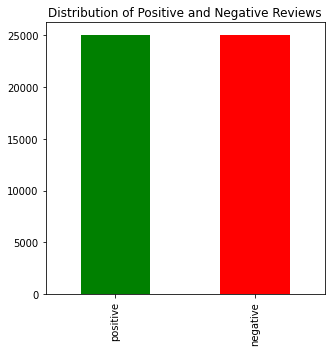

In [ ]:
df = pd.read_csv("IMDB Dataset.csv")

df["sentiment"].value_counts().plot(kind='bar',
                                    color=['green','red'],
                                    title='Distribution of Positive and Negative Reviews',
                                    figsize=(5,5));

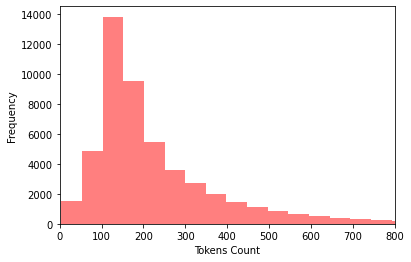

In [ ]:
plot_tokens_count(df, colmun_name="review")

In [ ]:
df = preprocess_data(df, "review")

### Config

In [ ]:
class Config:
  MAX_LEN = 384
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 4
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  BERT_PATH = "bert-base-uncased"
  MODEL_PATH = "BERTModel.bin"
  TRAINING_DATA = "IMDB Dataset.csv"

  TOKENIZER = transformers.BertTokenizer.from_pretrained(BERT_PATH, do_lower_case = True)
  MODEL = transformers.BertModel.from_pretrained(BERT_PATH, return_dict=False)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Dataset

In [ ]:
class DataProcess:
  def __init__(self, review):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN
    self.review = review
    
  def preprocess_bert(self):
    reviw = " ".join(self.review.split())
    inputs = self.tokenizer.encode_plus(
        reviw,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return (
        torch.tensor(input_ids, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0),
        torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0)
        )
    
  def preprocess_output(self, outputs):
    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs[0][0]

class MovieReviewDatSet:
  def __init__(self, df):
    
    self.data = df.fillna('none')
    self.data.sentiment = self.data.sentiment.apply(lambda x: 1 if x == "positive" else 0)
    self.data = self.data.reset_index(drop=True)
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN
    self.review = self.data.review.values
    self.label = self.data.sentiment.values

  def __len__(self):
    return len(self.review)

  def __getitem__(self, item):
    review = str(self.review[item])
    review = " ".join(review.split())

    inputs = self.tokenizer.encode_plus(
        review,
        None,
        add_special_tokens = True,
        max_length = self.max_len,
        padding = "max_length",
        truncation= True
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    return {
        "input_ids" : torch.tensor(input_ids, dtype=torch.long),
        "attention_mask" : torch.tensor(attention_mask, dtype=torch.long),
        "token_type_ids" : torch.tensor(token_type_ids, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
        }

### Model

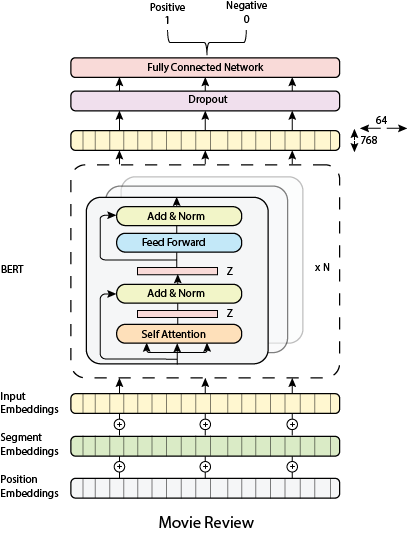

In [ ]:
class BERTModel(nn.Module):
  def __init__(self):
    super(BERTModel, self).__init__()
    self.bert = Config.MODEL
    self.bert_drop = nn.Dropout(0.3)
    self.out = nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask, token_type_ids):
    _, pooled_output  = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
    bo = self.bert_drop(pooled_output)
    output = self.out(bo)
    
    return output

### Engine

In [ ]:
def loss_fn(outputs, labels):
  return nn.BCEWithLogitsLoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    token_type_ids = d["token_type_ids"]
    labels = d["labels"]

    input_ids = input_ids.to(device, dtype=torch.long)
    attention_mask = attention_mask.to(device, dtype=torch.long)
    token_type_ids = token_type_ids.to(device, dtype = torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
    loss = loss_fn(outputs, labels)
    
    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      token_type_ids = d["token_type_ids"]
      labels = d["labels"]

      input_ids = input_ids.to(device, dtype=torch.long)
      attention_mask = attention_mask.to(device, dtype=torch.long)
      token_type_ids = token_type_ids.to(device, dtype = torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
      
      loss = loss_fn(outputs, labels)
      final_loss += loss.item()
      
      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      

  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

### **Train**

In [ ]:
dataset = MovieReviewDatSet(df)

train_data, valid_data = train_test_split(dataset, test_size = 0.1)
train_dataloader = DataLoader(train_data, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)
valid_dataloader = DataLoader(valid_data, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model = BERTModel()
model.to(Config.DEVICE)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(train_data) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

history = defaultdict(list)

best_accuracy = 0
for epoch in range(1, Config.EPOCHS+1):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)
  
  train_outputs = np.array(train_outputs) >= 0.5
  valid_outputs = np.array(valid_outputs) >= 0.5

  train_accuracy = metrics.accuracy_score(train_labels, train_outputs)
  valid_accuracy = metrics.accuracy_score(valid_labels, valid_outputs)

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train Accuracy: {train_accuracy} \nValid Loss: {valid_loss} - Valid Accuracy: {valid_accuracy}\n")
  
  history['Train Loss'].append(train_loss)
  history['Train Accuracy'].append(train_accuracy)
  history['Valid Loss'].append(valid_loss)
  history['Valid Accuracy'].append(valid_accuracy)
  
  if valid_accuracy > best_accuracy:
    torch.save(model.state_dict(), Config.MODEL_PATH)
    best_accuracy = valid_accuracy

100%|██████████| 1250/1250 [01:08<00:00, 18.31it/s]


Epoch: 1
Train Loss: 0.2757239613210162 - Train Accuracy: 0.8831777777777777 
Valid Loss: 0.2200824697446078 - Valid Accuracy: 0.9214



100%|██████████| 1250/1250 [01:08<00:00, 18.36it/s]


Epoch: 2
Train Loss: 0.12527461200652437 - Train Accuracy: 0.9554666666666667 
Valid Loss: 0.24516915981424972 - Valid Accuracy: 0.9156



100%|██████████| 1250/1250 [01:08<00:00, 18.32it/s]


Epoch: 3
Train Loss: 0.05001340337238378 - Train Accuracy: 0.9850222222222222 
Valid Loss: 0.320668875110941 - Valid Accuracy: 0.9206



100%|██████████| 1250/1250 [01:08<00:00, 18.37it/s]


Epoch: 4
Train Loss: 0.02098716766180781 - Train Accuracy: 0.9950444444444444 
Valid Loss: 0.3524849311555503 - Valid Accuracy: 0.922



### Error Analysis & Performance auditing

In [ ]:
def get_metrics(labels, outputs):
  accuracy = metrics.accuracy_score(labels, outputs)
  recall = metrics.recall_score(labels, outputs)
  precision = metrics.precision_score(labels, outputs)
  f1 = metrics.f1_score(labels, outputs)
  return accuracy, recall, precision, f1


Results summary

Accuracy Score  : 0.922
Recall Score    : 0.9262128006522625
Precision Score : 0.9157597742845627
F1 Score        : 0.9209566274827725

Classification report 

               precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      2547
         1.0       0.92      0.93      0.92      2453

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



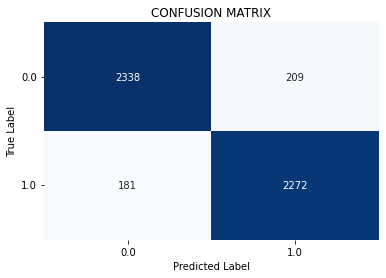

In [ ]:
accuracy, recall, precision, f1 = get_metrics(valid_labels, valid_outputs)

print("==="*50)
print("\nResults summary\n")
print(f"Accuracy Score  : {accuracy}")
print(f"Recall Score    : {recall}")
print(f"Precision Score : {precision}")
print(f"F1 Score        : {f1}")

print("==="*50)
print("\nClassification report \n\n", metrics.classification_report(valid_labels, valid_outputs))

print("==="*50)
cm = metrics.confusion_matrix(valid_labels, valid_outputs)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Predicted Label", 
       ylabel="True Label", 
       xticklabels=np.unique(valid_labels), 
       yticklabels=np.unique(valid_labels), 
       title="CONFUSION MATRIX")
plt.yticks(rotation=0);

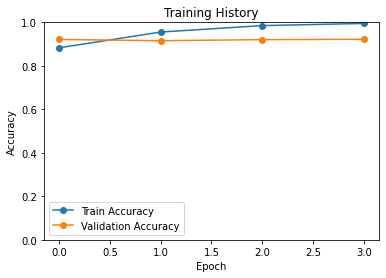

In [ ]:
plt.plot(history['Train Accuracy'], '-o', label='Train Accuracy')
plt.plot(history['Valid Accuracy'], '-o', label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

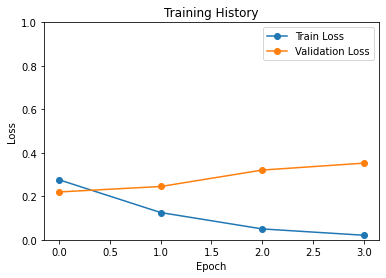

In [ ]:
plt.plot(history['Train Loss'], '-o', label='Train Loss')
plt.plot(history['Valid Loss'], '-o', label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Inference

In [ ]:
model = BERTModel()
model.to(Config.DEVICE)
model.load_state_dict(
    torch.load(
        Config.MODEL_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(review: str):
  data = DataProcess(review)
  input_ids, attention_mask, token_type_ids = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  token_type_ids = token_type_ids.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model(input_ids, attention_mask, token_type_ids) 
  positive_prediction = data.preprocess_output(outputs)
  negative_prediction = 1 - positive_prediction
  
  return {
      "review": review,
      "positive": str(positive_prediction),
      "negative": str(negative_prediction),
  }

In [ ]:
sentiment = predict("I like this amazing movie")
print(sentiment)

{'review': 'I like this amazing movie', 'positive': '0.9939493', 'negative': '0.006050705909729004'}


### References:

* **Jacob Devlin, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. 2019. [BERT: Pre-training of deep bidirectional transformers for language understanding](https://arxiv.org/abs/1810.04805). In North American Association for Computational Linguistics (NAACL). arXiv preprint arXiv:1810.04805.**
